In [1]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sns

In [2]:
# Read CSV file and assign the right column names
df = pd.read_csv(
    'mount/results/results.csv',
    names=[
        'uid','ticker','date','price_open','adx','ppo','stochastic',
        'maperiod','rsi_open_period','rsi_close_period','adx_period',
        'ppo_period_short','ppo_period_long','stochastic_period',
        'days_ago_close_period', 'price_sell'
    ]
)
print(len(df))
df.sample(5)

28874


,uid,ticker,date,price_open,adx,ppo,stochastic,maperiod,rsi_open_period,rsi_close_period,adx_period,ppo_period_short,ppo_period_long,stochastic_period,days_ago_close_period,price_sell
16595,9bf0aea0-a5af-11eb-b56a-00155d798062,AES,2020-02-25,18.75,36.116865,0.396719,25.498122,275,10,32,14,12,26,14,8,17.62
2691,17b271dc-a5af-11eb-b6b6-00155d798062,ABT,2019-10-08,76.39,26.171349,-1.308428,30.531732,225,6,34,14,12,26,14,8,77.36
1328,12abcb70-a5af-11eb-8596-00155d798062,ABT,2019-08-05,80.92,29.398146,0.813538,38.568152,175,6,26,14,12,26,14,10,82.57
3916,1fa2570e-a5af-11eb-a386-00155d798062,ABT,2020-02-24,83.03,13.714872,-0.090773,27.266366,275,10,26,14,12,26,14,12,80.07
20492,43e9f3a8-a5b2-11eb-94b4-00155d798062,ABBV,2020-07-31,91.44,19.202337,0.337611,19.351370,175,6,28,14,12,26,14,11,92.43


In [3]:
# Drop that UID cuz I'm not sure why I added it in the first place...
df = df.drop(['uid'], axis=1)

# Show a RANDOM sample to get a feel for the data 
print(len(df))
df.sample(5)

28874


,ticker,date,price_open,adx,ppo,stochastic,maperiod,rsi_open_period,rsi_close_period,adx_period,ppo_period_short,ppo_period_long,stochastic_period,days_ago_close_period,price_sell
13555,AES,2019-04-17,16.60,16.722056,0.335885,18.262108,175,6,26,14,12,26,14,12,16.62
23114,ATVI,2020-09-08,75.81,15.978653,-0.450567,18.999881,150,10,26,14,12,26,14,12,79.21
580,ABT,2019-10-02,77.39,23.656490,-0.989302,23.217523,256,8,32,14,12,26,14,8,78.88
391,ALK,2020-01-07,65.81,13.915062,-0.599975,12.385321,256,8,32,14,12,26,14,8,66.12
19652,ABT,2020-01-13,83.16,11.759128,0.156053,15.828155,275,6,28,14,12,26,14,10,84.12


In [4]:
# Add the percentage change for the price
df['perc_change'] = (df['price_sell'] - df['price_open']) / df['price_open'] * 100

# The prices can now be dropped since I won't need them anymore
df = df.drop(['price_sell', 'price_open'], axis=1)
print(len(df))
df.sample(3)

28874


,ticker,date,adx,ppo,stochastic,maperiod,rsi_open_period,rsi_close_period,adx_period,ppo_period_short,ppo_period_long,stochastic_period,days_ago_close_period,perc_change
14805,AES,2019-05-07,26.304946,-1.462841,14.294962,200,14,30,14,12,26,14,10,-1.856594
11878,AMD,2020-09-08,31.139201,3.600134,22.450151,250,6,32,14,12,26,14,10,4.092007
22188,ABBV,2020-09-24,28.084867,-1.977664,9.257456,250,12,26,14,12,26,14,11,0.374532


In [5]:
# Best portfolio values is a function of number of trades and trade outcome
# Each 'perc_change' should be applied *in order* to a 100 initial value
def outcome_computation(x):
    result = 1
    for _, perc_change in x.sort_values(['date'])['perc_change'].items():
        result += (result * perc_change) / 100

    return pd.Series(result, index=['outcome'])

grouped_df = df.groupby(['maperiod', 'rsi_open_period', 'rsi_close_period', 'days_ago_close_period']).apply(outcome_computation)
print(len(grouped_df))
grouped_df.sample()

751


,,,,outcome
maperiod,rsi_open_period,rsi_close_period,days_ago_close_period,
175,6,28,12,1.566227


In [6]:
# Find the biggest possible profit value
max_profit = grouped_df.max()
max_profit

outcome    683.81305
dtype: float64

In [7]:
# Find the biggest possible profit combination, the idea is that there will be only one in the end
max_df = grouped_df.loc[grouped_df['outcome'] == max_profit[0]]
max_df


,,,,outcome
maperiod,rsi_open_period,rsi_close_period,days_ago_close_period,
256,8,32,8,683.81305


In [8]:
# Manually change these values from above as best as possible
best_maperiod = 256
best_rsi_open_period = 8
best_rsi_close_period = 32
best_days_ago_close_period = 8

In [9]:
# Filter out less profitable setups
df = df[
    (df['maperiod']==best_maperiod) & 
    (df['rsi_open_period']==best_rsi_open_period) & 
    (df['rsi_close_period']==best_rsi_close_period) & 
    (df['days_ago_close_period']==best_days_ago_close_period)
]
print(len(df))
df.sample(3)

764


,ticker,date,adx,ppo,stochastic,maperiod,rsi_open_period,rsi_close_period,adx_period,ppo_period_short,ppo_period_long,stochastic_period,days_ago_close_period,perc_change
495,A,2019-05-13,32.002156,-0.973854,40.988051,256,8,32,14,12,26,14,8,2.945224
472,ABBV,2020-03-12,23.159683,-1.570697,25.125590,256,8,32,14,12,26,14,8,8.600109
60,ABBV,2020-01-23,26.249924,0.213047,20.445045,256,8,32,14,12,26,14,8,-1.062899


In [10]:
# Drop 'maperiod', 'rsi_open_period', 'rsi_close_period', 'days_ago_close_period' since I won't need them after this
df = df.drop(['maperiod', 'rsi_open_period', 'rsi_close_period', 'days_ago_close_period'], axis=1)
df.sample(3)

,ticker,date,adx,ppo,stochastic,adx_period,ppo_period_short,ppo_period_long,stochastic_period,perc_change
205,AES,2019-04-26,15.733203,-0.333699,14.821654,14,12,26,14,-6.902871
196,ATVI,2020-09-04,14.152656,0.150582,40.304592,14,12,26,14,0.737632
367,AMD,2020-02-27,25.715420,-0.025838,5.899108,14,12,26,14,7.839127


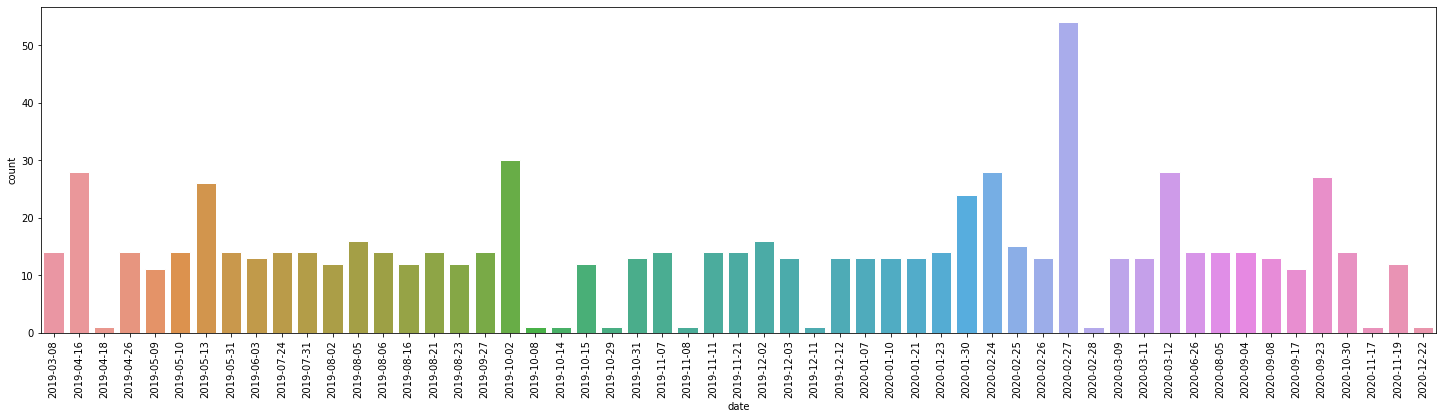

In [11]:
# Find the frequency distribution of trades
a4_dims = (25, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")

date_sorted_df = df.sort_values('date')
ax = sns.countplot(ax=ax, x='date', data=date_sorted_df)
wtfx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

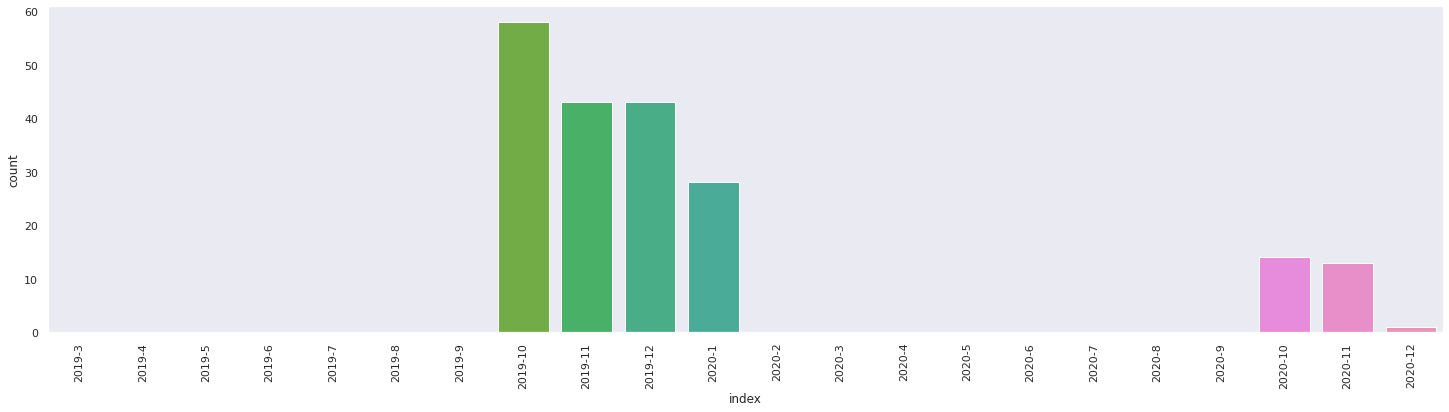

In [12]:
# Find the frequency distribution of trades and also show each month, count trades in a month
min_year, min_month, _ = date_sorted_df.iloc[0]['date'].split('-')
max_year, max_month, _ = date_sorted_df.iloc[-1]['date'].split('-')
max_year, max_month, min_year, min_month = [int(x) for x in [max_year, max_month, min_year, min_month]] 

monthly_data = {}

for year in range(min_year, max_year + 1):
    for month in range(min_month, 13):
        a = len(df[df['date'].str.startswith(f'{year}-{month}')])
        monthly_data[f'{year}-{month}'] = a
    min_month = 1

monthly_df = pd.DataFrame(monthly_data, index=['count']).transpose().reset_index()

a4_dims = (25, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")

ax = sns.barplot(ax=ax, x="index", y="count", data=monthly_df)
wtfx = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [13]:
# Add the 'is_profitable' column
df["is_profitable"] = df['perc_change'] > 0
print(len(df))
df.sample(3)

764


,ticker,date,adx,ppo,stochastic,adx_period,ppo_period_short,ppo_period_long,stochastic_period,perc_change,is_profitable
301,ABBV,2020-01-23,26.249924,0.213047,20.445045,14,12,26,14,-1.062899,False
738,AES,2019-04-26,15.733203,-0.333699,14.821654,14,12,26,14,-6.902871,False
10,ATVI,2020-02-27,23.179286,0.371678,12.197667,14,12,26,14,3.866829,True


<AxesSubplot:xlabel='adx', ylabel='ppo'>

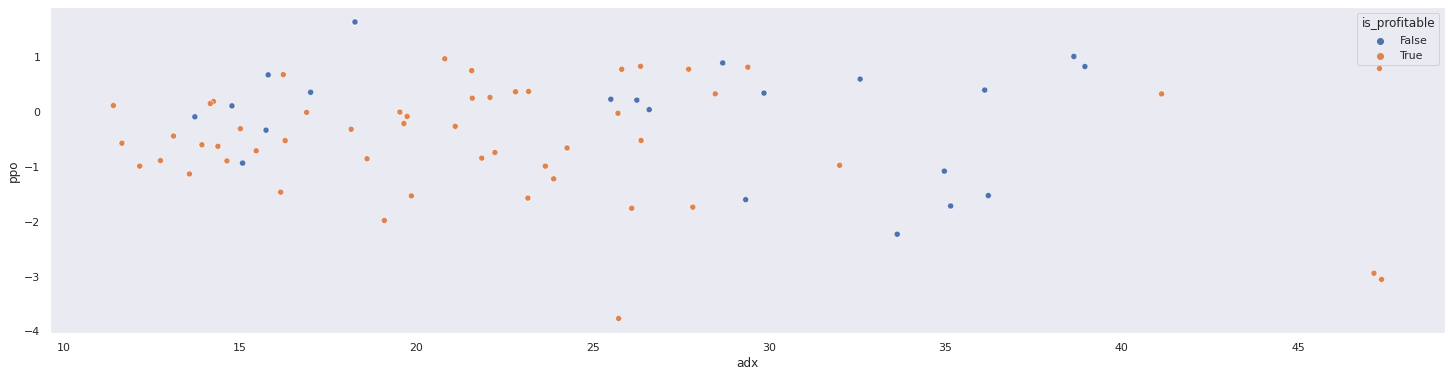

In [14]:
a4_dims = (25, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")
sns.scatterplot(ax=ax, data=df, x="adx", y="ppo", hue="is_profitable")

<AxesSubplot:xlabel='adx', ylabel='stochastic'>

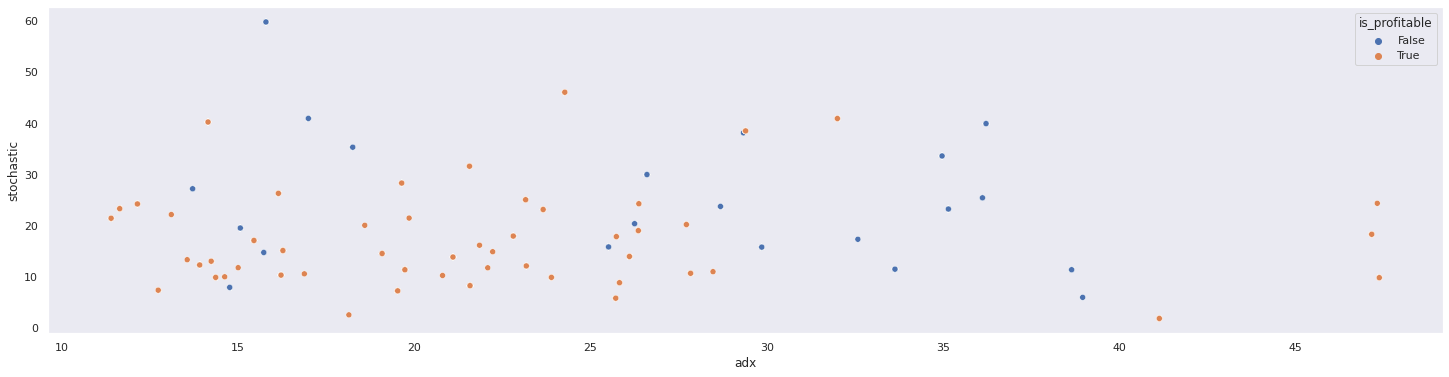

In [15]:
a4_dims = (25, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")
sns.scatterplot(ax=ax, data=df, x="adx", y="stochastic", hue="is_profitable")

<AxesSubplot:xlabel='ppo', ylabel='stochastic'>

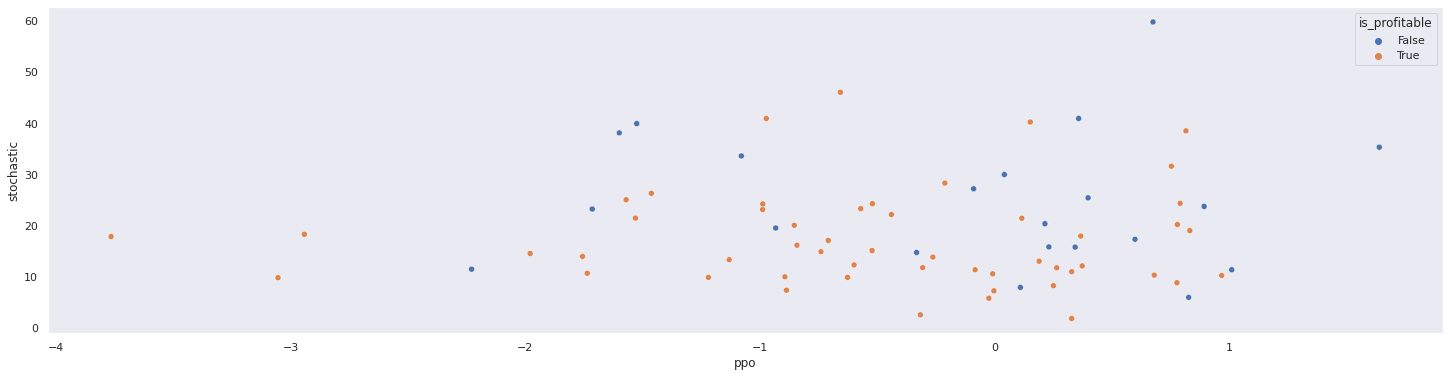

In [16]:
a4_dims = (25, 6)
fig, ax = pyplot.subplots(figsize=a4_dims)

sns.set_theme(style="dark")
sns.scatterplot(ax=ax, data=df, x="ppo", y="stochastic", hue="is_profitable")

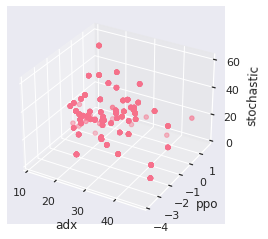

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

sns.set(style ="darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

x = df['adx']
y = df['ppo']
z = df['stochastic']

ax.set_xlabel("adx")
ax.set_ylabel("ppo")
ax.set_zlabel("stochastic")

ax.scatter(x, y, z, c=df['is_profitable'], cmap=cmap)

plt.show()